In [ ]:
#| default_exp ocr

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300

In [2]:

import copy
import os
import pickle
from PIL import Image

from typing import Callable, List

import numpy as np

from transformers import LayoutLMv2Processor

from experiment_utils.constants import *
from experiment_utils.utils import getLogger, get_sample_videos_paths, get_data_path

from csgo_clips_autotrim.feature_extraction import get_downsampled_frames, DownsampleConfig

In [3]:
layoutLM_processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

In [4]:
def denormalize_bboxes(img, bboxes):
    h, w, _ = img.shape
    x_factor, y_factor = w / 1000, h / 1000
    mult_vec = np.tile(np.array([x_factor, y_factor]), 2)
    
    normalized_bboxes = [bbox * mult_vec for bbox in bboxes[0]]

    return normalized_bboxes

def draw_bbox(img, bboxes):
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    for idx, bbox in enumerate(denormalize_bboxes(img, bboxes)):
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], alpha=0.4, label=idx)
        plt.annotate(f'[{idx}]', (bbox[0], bbox[1]), )
        ax.add_patch(rect)
    
    plt.show()

In [45]:
frames = get_downsampled_frames((DATA_DIR / 'test_clip_1.mp4').as_posix(), downsample_config=DownsampleConfig.from_str('downsample_1920x1080_60_RGB'))

[INFO] 2022-10-02 20:25:50,315 root        : Getting video size for '/code/data/test_clip_1.mp4'


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


6360it [00:34, 186.07it/s]                                                                                                                                                                                                                  


In [46]:
with open(os.path.join(DATA_DIR, f'test_clip_1_frames.pickle'), 'wb') as f:
    pickle.dump(frames, f)

In [47]:
def try_ocr_on_image(image):
    encoding = layoutLM_processor(image, return_tensors="pt")
    draw_bbox(image, encoding['bbox'])

In [48]:
len(frames)

106

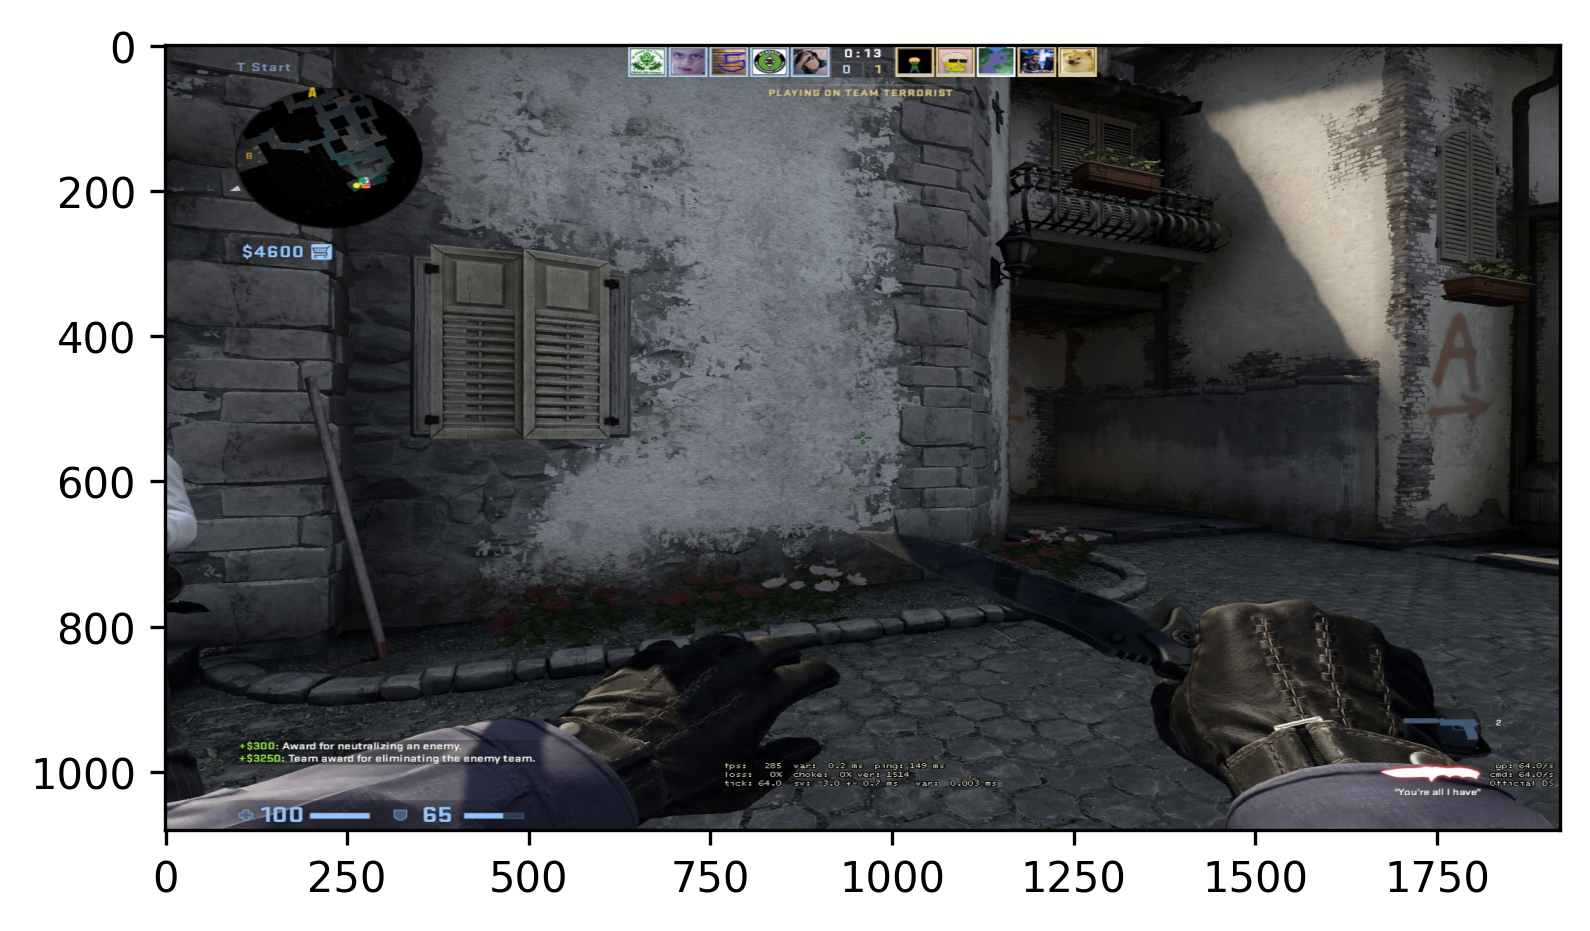

In [49]:
plt.imshow(frames[-1], cmap='gray')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


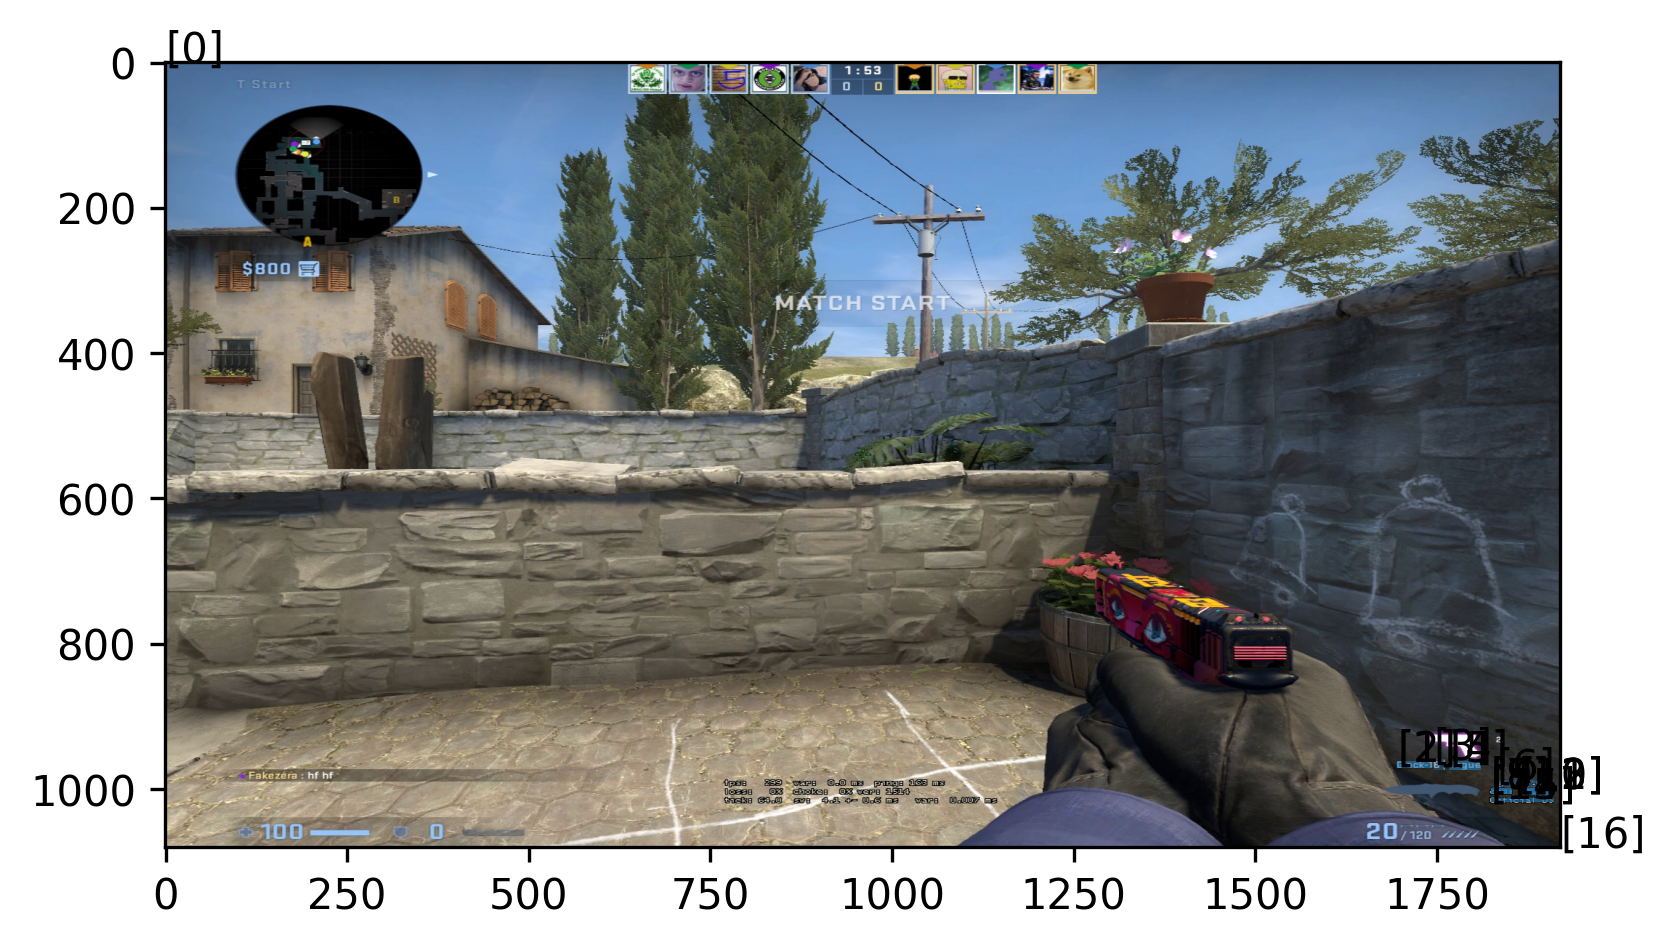

In [51]:
try_ocr_on_image(frames[0])

### Trying cv2 transforms to improve OCR perf



In [52]:
import cv2

In [53]:
def convert_to_grayscale_and_threshold(img: np.ndarray):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh_rgb = cv2.merge([thresh, thresh, thresh])
    
    return thresh_rgb

In [54]:
def get_quadrant(img: np.ndarray, top: bool, left: bool):
    height, width, *rest = img.shape
    
    top_left_x = 0 if top else height // 2
    top_left_y = 0 if left else width // 2
    bottom_right_x = height // 2 if top else height
    bottom_right_y = width // 2 if left else width
    
    return img[top_left_x:bottom_right_x, top_left_y:bottom_right_y]

In [55]:
def try_ocr_image_with_preprocessing(img, preprocessing_steps: List[Callable]):
    processed_image = copy.deepcopy(img)
    for step in preprocessing_steps:
        processed_image = step(processed_image)
    
    encoding = layoutLM_processor(processed_image, return_tensors="pt")
    draw_bbox(processed_image, encoding['bbox'])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


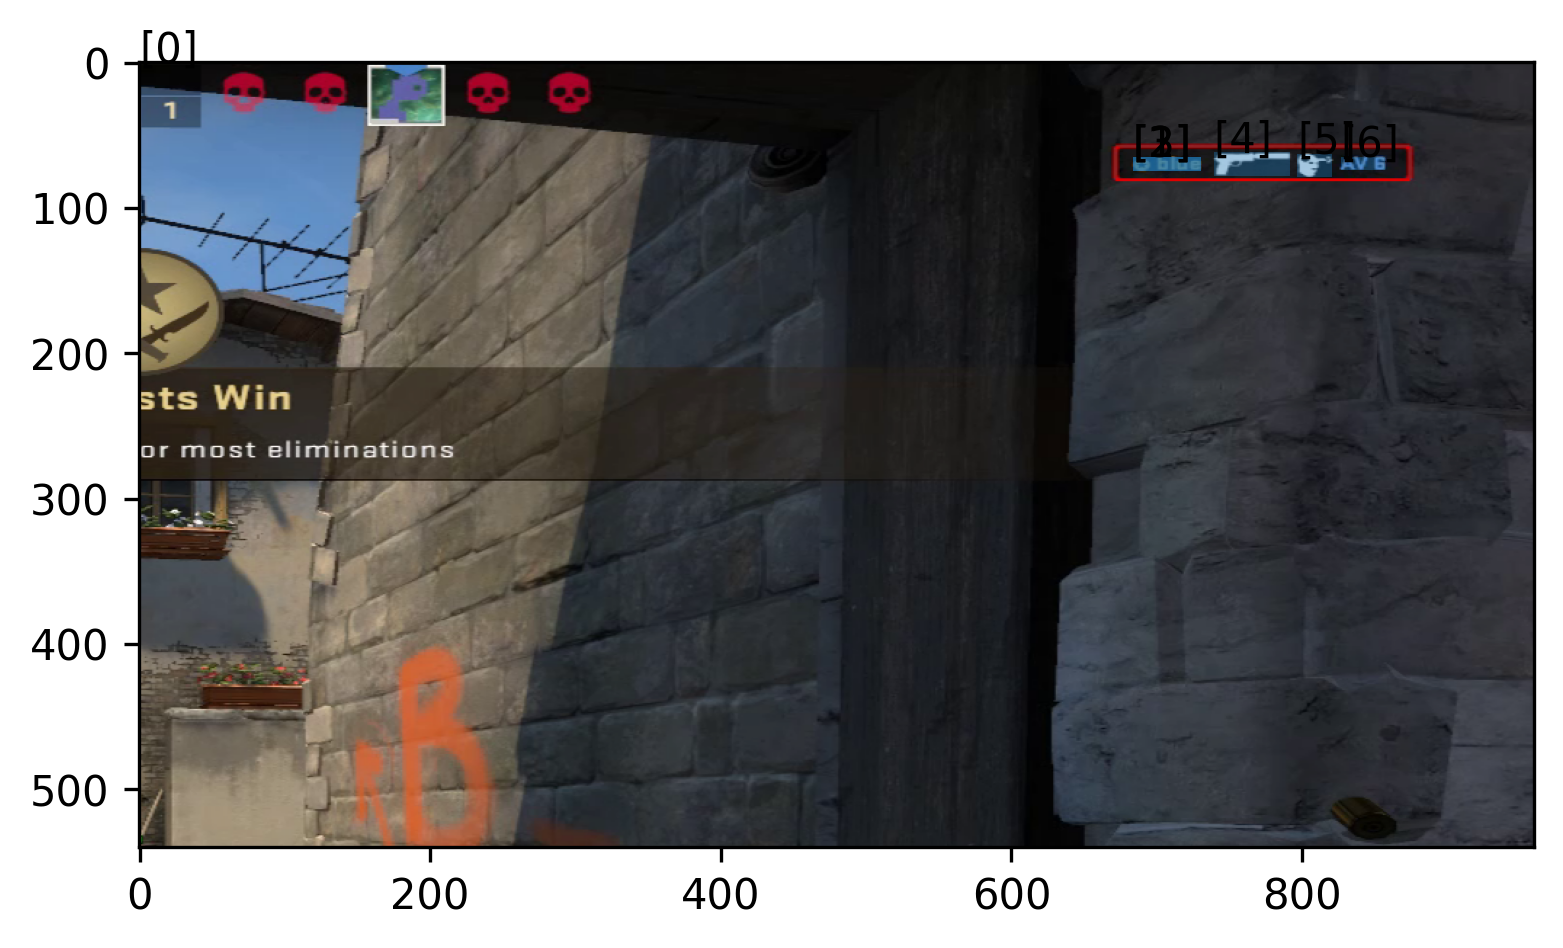

In [56]:
try_ocr_image_with_preprocessing(frames[-10], preprocessing_steps=[
    lambda x: get_quadrant(x, top=True, left=False),
#     lambda x: get_quadrant(x, top=True, left=False),
#     convert_to_grayscale_and_threshold,
])

In [57]:
top_right_quad = get_quadrant(frames[-10], top=True, left=False)
processing_result = layoutLM_processor(top_right_quad, return_length='pt')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [58]:
denorm_bboxes = denormalize_bboxes(top_right_quad, processing_result['bbox'])

In [59]:
def get_bbox(image: np.ndarray, bbox: np.ndarray):
    int_bbox = bbox.astype(int)
    return image[int_bbox[1]:int_bbox[3], int_bbox[0]:int_bbox[2]]

In [60]:
def show_bbox(image: np.ndarray, bbox: np.ndarray):
    plt.imshow(get_bbox(image, bbox))

In [61]:
import pytesseract

In [62]:
pytesseract.image_to_string(top_right_quad)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'oblue FR @ ave\n\n   \n\x0c'

In [103]:
blue_bbox = get_bbox(top_right_quad, denorm_bboxes[1])

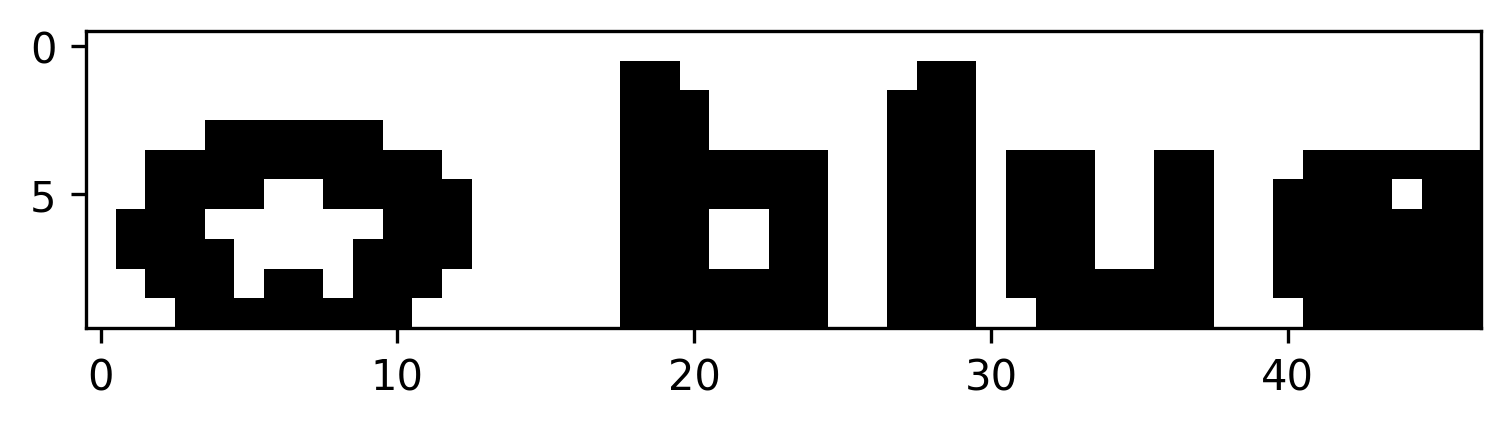

In [104]:
plt.imshow(convert_to_grayscale_and_threshold(blue_bbox))

In [175]:
# TODO: Mask out rest of the image and keep the bbox to extract the text?
masked_image = np.full_like(top_right_quad, 0)

In [183]:
blue_bbox_bounds = copy.deepcopy(denorm_bboxes[1].astype(int))

In [184]:
blue_bbox_bounds

array([683,  64, 730,  74])

In [185]:
blue_bbox_symbol_removed = blue_bbox[:, 15:]
blue_bbox_bounds_symbol_removed = blue_bbox_bounds.copy()
blue_bbox_bounds_symbol_removed[0] += 15

In [186]:
blue_bbox_symbol_removed.shape

(10, 32, 3)

In [187]:
blue_bbox_bounds_symbol_removed

array([698,  64, 730,  74])

In [188]:
masked_image[blue_bbox_bounds_symbol_removed[1]:blue_bbox_bounds_symbol_removed[3], blue_bbox_bounds_symbol_removed[0]:blue_bbox_bounds_symbol_removed[2]] = blue_bbox_symbol_removed

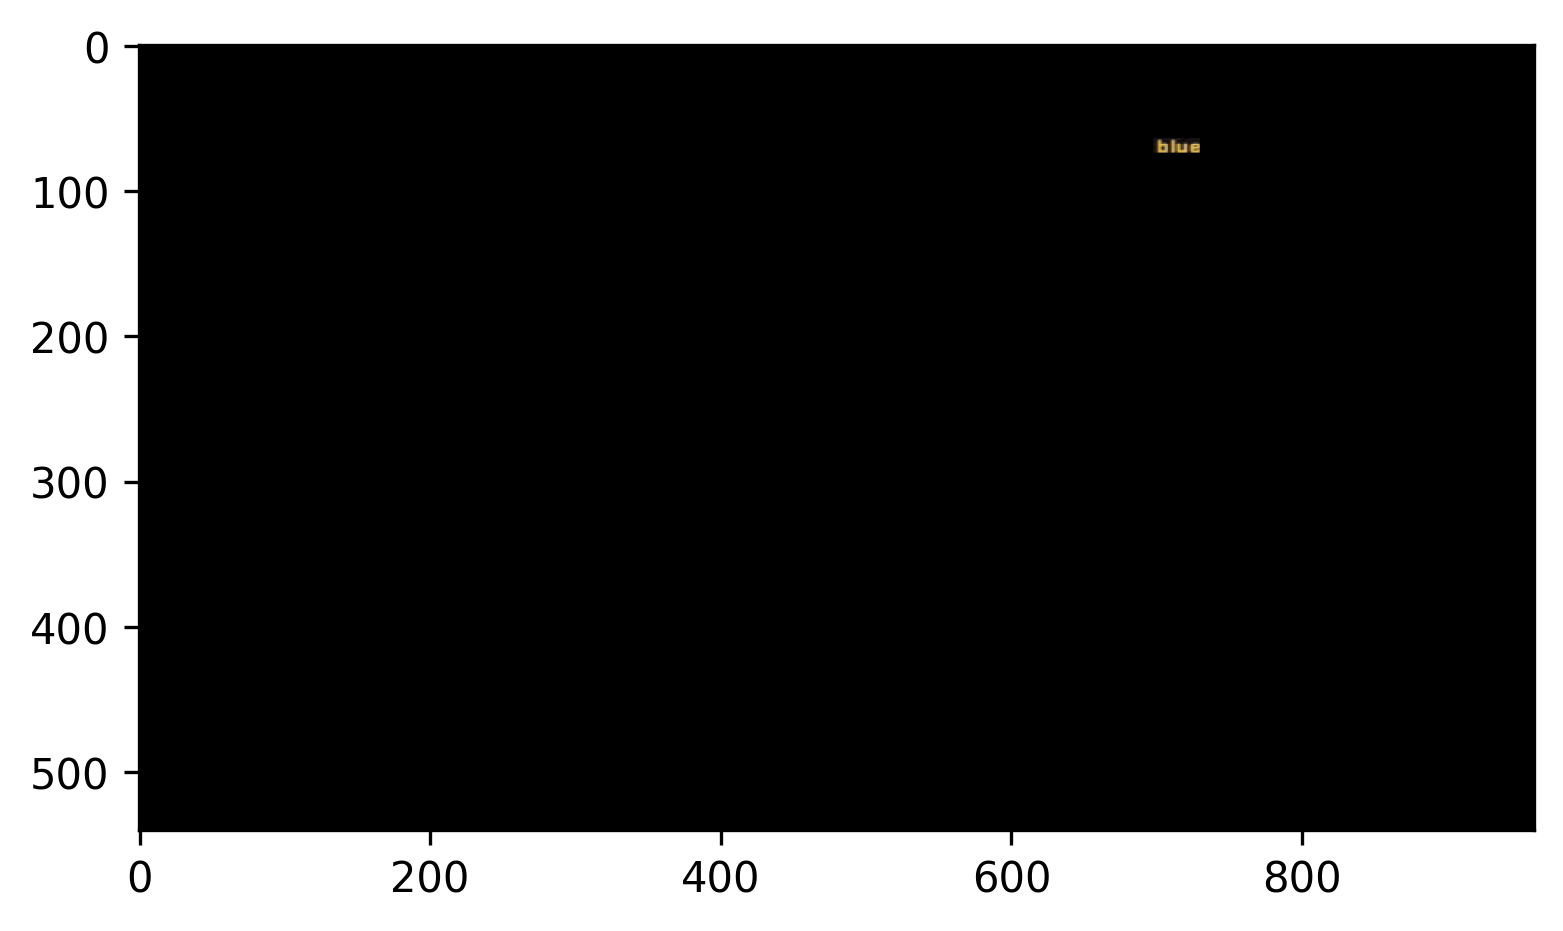

In [189]:
plt.imshow(masked_image)

In [190]:
pytesseract.image_to_string(masked_image, lang='eng',config='-c page_separator=')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


''

In [191]:
masked_top = (get_quadrant(masked_image, top=True, left=False))

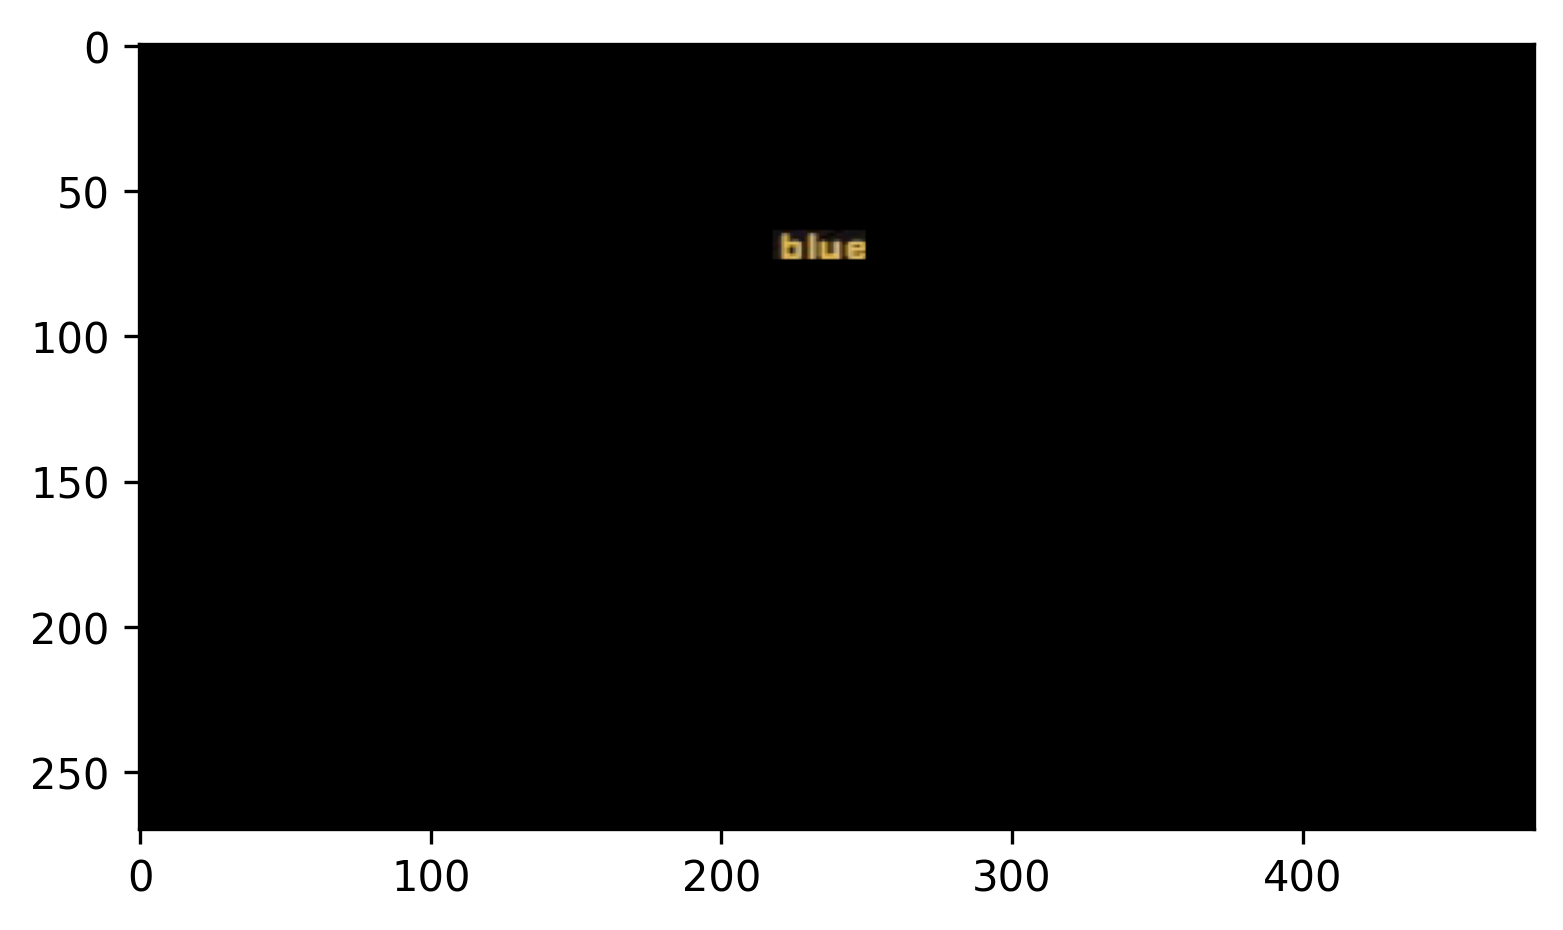

In [192]:
plt.imshow(masked_top)

In [90]:
pytesseract.image_to_string(masked_image, lang='eng',config='-c page_separator=')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


''